<a href="https://colab.research.google.com/github/mralamdari/Computer-Vision-Projects/blob/main/Arthropod_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [Arthropod Taxonomy Orders Object Detection Dataset](https://www.kaggle.com/datasets/mistag/arthropod-taxonomy-orders-object-detection-dataset/)

In [ ]:
import os
import sys
import json
import pprint
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib as mpl
import concurrent.futures
from threading import Lock
# import json, math, random, os, pprint,sys
from matplotlib import pyplot as plt
AUTO = tf.data.AUTOTUNE
pp = pprint.PrettyPrinter()
!pip install --quiet tf-models-official==2.9.2
from tensorflow_models.vision import box_ops as box
sys.path.append('PATH_TO_TENSORFLOW_OBJECT_DETECTION_FOLDER')# load all the metadata

In [ ]:
os.environ['KAGGLE_CONFIG_DIR']='/content/drive/MyDrive/'
!kaggle datasets download -d mistag/arthropod-taxonomy-orders-object-detection-dataset
!unzip *.zip && rm *.zip

# PerProcessing

In [ ]:
IMAGES_PER_SHARD = 481
TARGET_WIDTH = 1024

CLASSES = ['Lepidoptera', 'Hymenoptera', 'Hemiptera', 'Odonata', 'Diptera', 'Araneae', 'Coleoptera']

RAW_CLASSES = CLASSES + ['_truncated', '_blurred', '_occluded']

In [ ]:
class Progress:
    """Text mode progress bar.
    Usage:
            p = Progress(30)
            p.step()
            p.step()
            p.step(start=True) # to restart form 0%
    The progress bar displays a new header at each restart."""
    def __init__(self, maxi, size=100, msg=""):
        """
        :param maxi: the number of steps required to reach 100%
        :param size: the number of characters taken on the screen by the progress bar
        :param msg: the message displayed in the header of the progress bat
        """
        self.maxi = maxi
        self.p = self.__start_progress(maxi)()  # () to get the iterator from the generator
        self.header_printed = False
        self.msg = msg
        self.size = size
        self.lock = Lock()

    def step(self, reset=False):
        with self.lock:
            if reset:
                self.__init__(self.maxi, self.size, self.msg)
            if not self.header_printed:
                self.__print_header()
            next(self.p)

    def __print_header(self):
        print()
        format_string = "0%{: ^" + str(self.size - 6) + "}100%"
        print(format_string.format(self.msg))
        self.header_printed = True

    def __start_progress(self, maxi):
        def print_progress():
            # Bresenham's algorithm. Yields the number of dots printed.
            # This will always print 100 dots in max invocations.
            dx = maxi
            dy = self.size
            d = dy - dx
            for x in range(maxi):
                k = 0
                while d >= 0:
                    print('=', end="", flush=True)
                    k += 1
                    d -= dx
                d += dy
                yield k

        return print_progress

    
def no_decorations(ax):
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    

def display_detections(images, offsets, resizes, detections, classnames, ground_truth_boxes=[]):
    # scale and offset the detected boxes back to original image coordinates
    boxes   = [[ (x,y,w,h)  for _, x, y, w, h, score, klass in detection_list] for detection_list in detections]
    boxes   = [[ (x-ofs[1], y-ofs[0], w, h) for x,y,w,h in boxlist ] for boxlist, ofs in zip(boxes, offsets)]
    boxes   = [[ (x*rsz, y*rsz, w*rsz, h*rsz) for x,y,w,h in boxlist ] for boxlist, rsz in zip(boxes, resizes)]
    classes = [[ int(klass) for _, x, y, w, h, score, klass in detection_list] for detection_list in detections]
    scores  = [[ score      for _, x, y, w, h, score, klass in detection_list] for detection_list in detections]
    display_with_boxes(images, boxes, classes, scores, classnames, ground_truth_boxes)
    
    
# images, boxes and classes must have the same number of elements
# scores can be en empty list []. If it is not empty, it must also
# have the same number of elements.
# classnames is the list of possible classes (strings)
def display_with_boxes(images, boxes, classes, scores, classnames, ground_truth_boxes=[]):
    N = len(images)
    sqrtN = int(np.ceil(np.sqrt(N)))
    aspect = sum([im.shape[1]/im.shape[0] for im in images])/len(images) # mean aspect ratio of images
    fig = plt.figure(figsize=(15,15/aspect), frameon=False)
    
    for k in range(N):
        ax = plt.subplot(sqrtN, sqrtN, k+1)
        no_decorations(ax)
        plt.imshow(images[k])
        
        if ground_truth_boxes:
            for box in ground_truth_boxes[k]:
                x, y, w, h = (box[0], box[1], box[2]-box[0], box[3]-box[1]) # convert x1 y1 x2 y2 into xywh
                #x, y, w, h = (box[0], box[1], box[2], box[3])
                rect = mpl.patches.Rectangle((x, y),w,h,linewidth=4,edgecolor='#FFFFFFA0',facecolor='none')
                ax.add_patch(rect)

        for i, (box, klass) in enumerate(zip(boxes[k], classes[k])):
            x, y, w, h = (box[0], box[1], box[2]-box[0], box[3]-box[1]) # convert x1 y1 x2 y2 into xywh
            #x, y, w, h = (box[0], box[1], box[2], box[3])
            #label = classnames[klass-1] # predicted classes are 1-based
            label = classnames[klass]
            if scores:
                label += ' ' + str(int(scores[k][i]*100)) + '%' 
            rect = mpl.patches.Rectangle((x, y),w,h,linewidth=4,edgecolor='#00000080',facecolor='none')
            ax.add_patch(rect)
            rect = mpl.patches.Rectangle((x, y),w,h,linewidth=2,edgecolor='#FFFF00FF',facecolor='none')
            ax.add_patch(rect)
            plt.text(x, y, label, size=16, ha="left", va="top", color='#FFFF00FF',
                     bbox=dict(boxstyle="round", ec='#00000080', fc='#0000004E', linewidth=3) )
            plt.text(x, y, label, size=16, ha="left", va="top", color='#FFFF00FF',
                     bbox=dict(boxstyle="round", ec='#FFFF00FF', fc='#0000004E', linewidth=1.5) )
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.02, hspace=0.02)
    plt.show()

In [ ]:
DATA_PATH = '/content/ArTaxOr/Araneae'
json_filename_pattern = '/content/ArTaxOr/Araneae/annotations/*.json'
jpeg_filename_pattern = '/content/ArTaxOr/Araneae/*.jpg'

def load_json(filename, p):
    p.step()
    with tf.io.gfile.GFile(filename, 'r') as f:
        return json.load(f)
    
def filename_key(filename):
    path, filename = os.path.split(filename)
    dirname = os.path.split(path)[1]
    return filename
    # return os.path.join(dirname, filename)
    
def load_metadata(filename_pattern, jpeg_filename_pattern):
    print("Scanning directory...", end=' ')
    json_filenames = tf.io.gfile.glob(json_filename_pattern)
    jpeg_filenames = tf.io.gfile.glob(jpeg_filename_pattern)
    print(f"found {len(json_filenames)} metadata files and {len(jpeg_filenames)} image files.")
    print("Loading metadata")
    p = Progress(len(json_filenames))
    with concurrent.futures.ThreadPoolExecutor() as exe:
        data = exe.map(lambda x: load_json(x,p), json_filenames)
    # data as a dictionary for easier cross-referencing
    data = {filename_key(d['asset']['path']):d for d in data}
    return data, jpeg_filenames

RAW_METADATA, JPEG_FILENAMES = load_metadata(json_filename_pattern, jpeg_filename_pattern)

Scanning directory... found 2418 metadata files and 2418 image files.
Loading metadata

0%                                                                                              100%

In [ ]:
name = JPEG_FILENAMES[0]
RAW_METADATA[name[-16:]]

{'asset': {'format': 'jpg',
  'id': 'b25575a4d90e8922ecb815e684638555',
  'name': '9cc9c7842d7b.jpg',
  'path': 'file:F:/ArTaxOr/Araneae/9cc9c7842d7b.jpg',
  'size': {'width': 5184, 'height': 3456},
  'state': 2,
  'type': 1},
 'regions': [{'id': 'Sojpn0NLA',
   'type': 'RECTANGLE',
   'tags': ['Araneae'],
   'boundingBox': {'height': 1272.3226473629782,
    'width': 1848.3641379310345,
    'left': 1805.4620689655173,
    'top': 1277.1251292657703},
   'points': [{'x': 1805.4620689655173, 'y': 1277.1251292657703},
    {'x': 3653.826206896552, 'y': 1277.1251292657703},
    {'x': 3653.826206896552, 'y': 2549.4477766287487},
    {'x': 1805.4620689655173, 'y': 2549.4477766287487}]}],
 'version': '2.1.0'}

In [ ]:
# Check that there is a model garden safe way of computing image ids.
# In the end, this does not matter. The ids are never used, but they must still be processed,
# otherwise the Model Garden data loader will crash on them.

# copied from Model Garden code
# = official/vision/beta/dataloaders/utils process_source_id()

def model_garden__str_to_int64(s):
    return tf.strings.to_number(s, tf.int64).numpy()

def compute_id_bytestring(s):
    
    computed_id = (int('0x' + s[:16], 16) ^ int('0x' + s[16:], 16)) & 0x0FFFFFFFFFFFFFFF
    return str(computed_id).encode('utf-8')

raw_ids = []
cnv_ids = []
cnv_cnv_ids = []

for i, key in enumerate(RAW_METADATA):
    iid = RAW_METADATA[key]['asset']['id']
    raw_ids.append(iid)
    iid = compute_id_bytestring(iid)
    #print("computed:", iid)
    cnv_ids.append(iid)
    iid = model_garden__str_to_int64(iid)
    cnv_cnv_ids.append(iid)

print(f"Original ids: {len(raw_ids)} Uniques:{len(set(raw_ids))} Collisions:{len(raw_ids) - len(set(raw_ids))}")
print(f"Original ids: {len(cnv_ids)} Uniques:{len(set(cnv_ids))} Collisions:{len(raw_ids) - len(set(cnv_ids))}")
print(f"Computed ids as converted by Model Garden:{len(cnv_cnv_ids)}, Uniques: {len(set(cnv_cnv_ids))}, Collisions: {len(raw_ids) - len(set(cnv_cnv_ids))}")

Original ids: 2418 Uniques:2418 Collisions:0
Original ids: 2418 Uniques:2418 Collisions:0
Computed ids as converted by Model Garden:2418, Uniques: 2418, Collisions: 0


/content/ArTaxOr/Araneae 272bc5e5bea1.jpg file:F:/ArTaxOr/Araneae/272bc5e5bea1.jpg
/content/ArTaxOr/Araneae f551b4370fba.jpg file:F:/ArTaxOr/Araneae/f551b4370fba.jpg
/content/ArTaxOr/Araneae 3c6491416c3f.jpg file:F:/ArTaxOr/Araneae/3c6491416c3f.jpg
/content/ArTaxOr/Araneae 8dde97c72478.jpg file:F:/ArTaxOr/Araneae/8dde97c72478.jpg


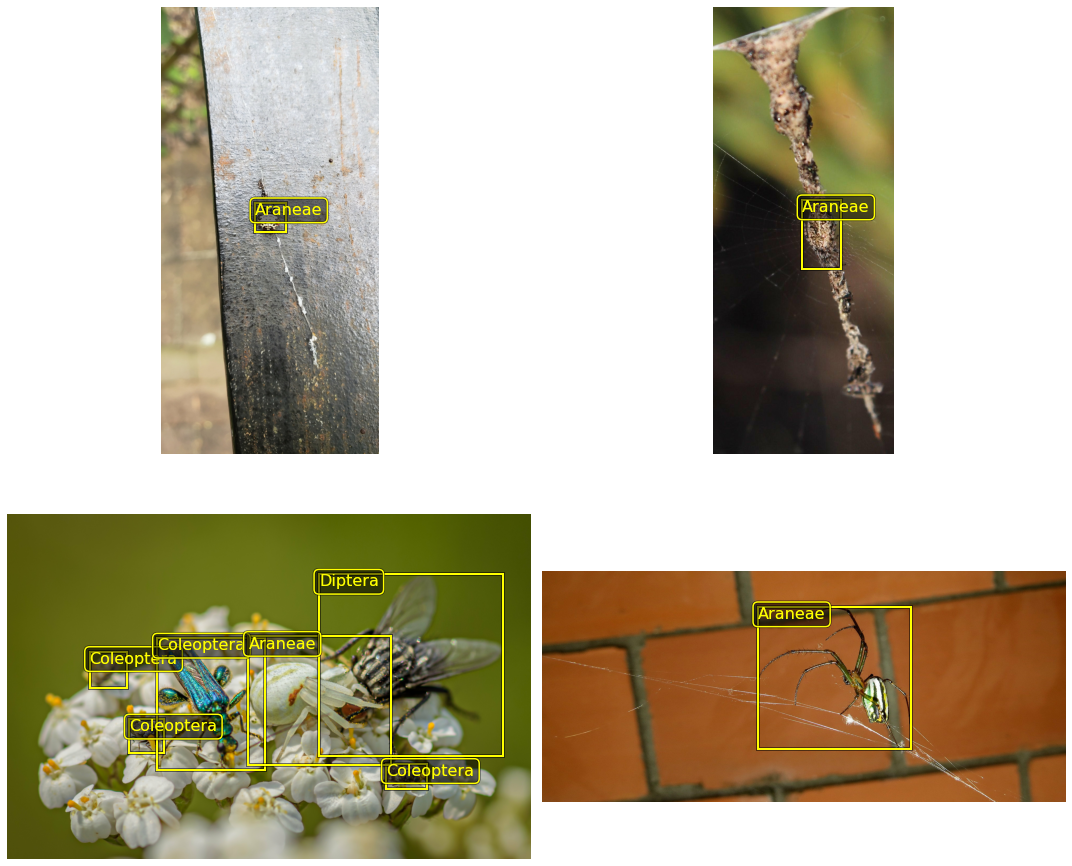

In [ ]:
# collect weird aspec ratio images and very large images
oddities = [d['asset']['path'] for k,d in RAW_METADATA.items() if d['asset']['size']['width']>5400]
oddities += [d['asset']['path'] for k,d in RAW_METADATA.items() if d['asset']['size']['height']>5000]
oddities2 = [d['asset']['path'] for k,d in RAW_METADATA.items() if d['asset']['size']['height']/d['asset']['size']['width']>1.9]
oddities2 += [d['asset']['path'] for k,d in RAW_METADATA.items() if d['asset']['size']['width']/d['asset']['size']['height']>2.0]

nice_pics = ['/ArTaxOr/Lepidoptera/e7d7b4678088.jpg','/ArTaxOr/Lepidoptera/e74f298859ff.jpg','/ArTaxOr/Coleoptera/92c9a15e7362.jpg',
             '/ArTaxOr/Coleoptera/a1824522fddc.jpg','/ArTaxOr/Hymenoptera/7188c0cc8c9d.jpg','/ArTaxOr/Lepidoptera/b7197aead30b.jpg',
             '/ArTaxOr/Lepidoptera/dfc9ece476e6.jpg','/ArTaxOr/Araneae/a1488eb130e3.jpg','/ArTaxOr/Coleoptera/39c0eabccc41.jpg']
alt_pics = ['/ArTaxOr/Araneae/3c6491416c3f.jpg','/ArTaxOr/Araneae/81ff08857d15.jpg',
            '/ArTaxOr/Hymenoptera/f8f10bc28f5b.jpg','/ArTaxOr/Lepidoptera/e314c31efafd.jpg']

#filenames = tf.io.gfile.glob('../input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr/*/*jpg')
#filenames = nice_pics
filenames = oddities+oddities2
#filenames = alt_pics

# display a couple of images from the raw_metadata with their bounding boxes
images = []
bboxes = []
taglists = []
np.random.shuffle(filenames)
for filename in filenames[:4]:
    print(DATA_PATH, filename_key(filename), filename)
    filepath = os.path.join(DATA_PATH, filename_key(filename))
    d = RAW_METADATA[filename_key(filename)]
    images.append(tf.image.decode_jpeg(tf.io.read_file(filepath)))
    bbxs = [region['boundingBox'] for region in d['regions']]
    # xywh to yxyx conversion
    bbxs = [[box['left'],box['top'], box['left']+box['width'], box['top']+box['height']] for box in bbxs]
    #tags = [region['tags'] for region in d['regions']] # all tags
    tags = [region['tags'][0] for region in d['regions']] # first tag only
    tags = [CLASSES.index(t) for t in tags] 
    bboxes.append(bbxs)
    taglists.append(tags)

display_with_boxes(images, bboxes, taglists, None, CLASSES, ground_truth_boxes=[])

In [ ]:
print('Nb entries:', len(RAW_METADATA))
print('Nb images:', len(JPEG_FILENAMES))
assert(len(RAW_METADATA) == len(JPEG_FILENAMES))

formats = set([d['asset']['format'] for k,d in RAW_METADATA.items()])
print('Image formats:', formats)
assert(len(formats)==1 and list(formats)[0]=='jpg')

states = set([d['asset']['state'] for k,d in RAW_METADATA.items()])
print('Image states(?):', states)
types = set([d['asset']['type'] for k,d in RAW_METADATA.items()])
print('Image types(?):', types)

widths = [d['asset']['size']['width'] for k,d in RAW_METADATA.items()]
print(f'Images widths range from {min(widths)} to {max(widths)}')
heights = [d['asset']['size']['height'] for k,d in RAW_METADATA.items()]
print(f'Images heights range from {min(heights)} to {max(heights)}')

aspect_ratios = [w/h for w,h in zip(widths, heights)]
print(f'Images aspect ratios range from {min(aspect_ratios)} to {max(aspect_ratios)}')

nbbox = [len(d['regions']) for k,d in RAW_METADATA.items()]
print(f'Nb of bounding boxes from {min(nbbox)} to {max(nbbox)}, average {sum(nbbox)/len(nbbox):.3}')

region_types = [set([t['type'] for t in d['regions']]) for k,d in RAW_METADATA.items()]
region_types = set().union(*region_types)
print('Region types:', region_types)
assert(len(region_types)==1 and list(region_types)[0]=='RECTANGLE')

region_tags = [[t['tags'] for t in d['regions']] for k,d in RAW_METADATA.items()]
region_tags = [sum(l,[]) for l in region_tags] # concat lists of tags across multiple regions
region_tags = set(sum(region_tags, [])) # concat all and make a set
print('Region tags:', region_tags)

bbox_width = [[t['boundingBox']['width'] for t in d['regions']] for k,d in RAW_METADATA.items()]
bbox_width = sum(bbox_width, []) # flatten the list
print(f'Bounding box widths range from {min(bbox_width)} to {max(bbox_width)}')

bbox_height = [[t['boundingBox']['height'] for t in d['regions']] for k,d in RAW_METADATA.items()]
bbox_height = sum(bbox_height, []) # flatten the list
print(f'Bounding box height range from {min(bbox_height)} to {max(bbox_height)}')

bbox_left = [[t['boundingBox']['left'] for t in d['regions']] for k,d in RAW_METADATA.items()]
bbox_left = sum(bbox_left, []) # flatten the list
print(f'Bounding box left range from {min(bbox_left)} to {max(bbox_left)}')

bbox_top = [[t['boundingBox']['top'] for t in d['regions']] for k,d in RAW_METADATA.items()]
bbox_top = sum(bbox_top, []) # flatten the list
print(f'Bounding box top range from {min(bbox_top)} to {max(bbox_top)}')

# compute aspect ratios in landscape mode
landscape_aspect_ratios = [w/h if w>h else h/w for w,h in zip(widths, heights)]
print(f'Images landscape aspect ratios range from {min(landscape_aspect_ratios)} to {max(landscape_aspect_ratios)}')

Nb entries: 2418
Nb images: 2418
Image formats: {'jpg'}
Image states(?): {2}
Image types(?): {1}
Images widths range from 500 to 5500
Images heights range from 375 to 4272
Images aspect ratios range from 0.4044418468731736 to 2.3703703703703702
Nb of bounding boxes from 1 to 34, average 1.11
Region types: {'RECTANGLE'}
Region tags: {'_truncated', '_blurred', 'Lepidoptera', 'Araneae', '_occluded', 'Coleoptera', 'Hymenoptera', 'Diptera', 'Hemiptera'}
Bounding box widths range from 29.42528735632184 to 3861.1984838042727
Bounding box height range from 29.42528735632184 to 3453.654601861427
Bounding box left range from 0 to 3980.0137835975193
Bounding box top range from 0 to 3089.1127197518094
Images landscape aspect ratios range from 1.0 to 2.472543352601156


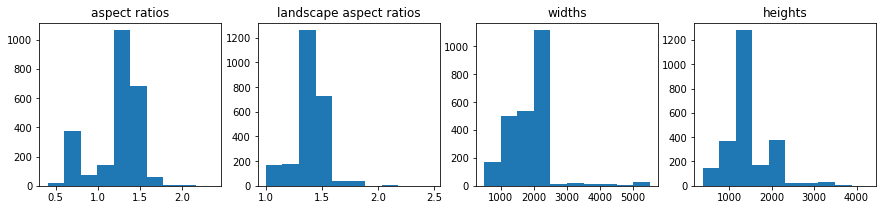

In [ ]:
fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4, figsize=(15,3))
ax1.set_title("aspect ratios")
ax1.hist(aspect_ratios)
ax2.set_title("landscape aspect ratios")
ax2.hist(landscape_aspect_ratios)
ax3.set_title("widths")
ax3.hist(widths)
ax4.set_title("heights")
ax4.hist(heights)
plt.show()

In [ ]:
def metadataset_from_image_filenames(filenames):
    values = [RAW_METADATA[filename_key(f)] for f in filenames]

    values = {'id': [filename_key(val['asset']['id']) for val in values],
              'fname': [os.path.join(DATA_PATH, filename_key(val['asset']['path'])) for val in values],
              'width':[val['asset']['size']['width'] for val in values],
              'height':[val['asset']['size']['height'] for val in values],
              # xywh to yxyx conversion ?
              # internal box format: x1 y1 x2 y2 in pixel coordinates
              'boxes': tf.ragged.constant([[(item['boundingBox']['left'],
                                             item['boundingBox']['top'],
                                             item['boundingBox']['left']+item['boundingBox']['width'],
                                             item['boundingBox']['top']+item['boundingBox']['height']) 
                                            for item in val['regions']] for val in values], ragged_rank=1), # must specify ragged rank, othewise tf.ragged.constant
                                                                               # does not detect that the last dim is 4 [x1 y1 x2 y2]
               'tags': tf.ragged.constant([[item['tags'] for item in val['regions']] for val in values]),
               'classes': tf.ragged.constant([[[CLASSES.index(tag) for tag in item['tags'] if tag in CLASSES] for item in val['regions']] for val in values])
              }

    metadataset = tf.data.Dataset.from_tensor_slices(values)
    return metadataset

In [ ]:
def decode_img(metadata):
    compressed_data = tf.io.read_file(metadata['fname'])
    image = tf.image.decode_jpeg(compressed_data, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32) # convert from uint8 [0,255] float [0,1)
    return image, metadata

def keep_one_tag_per_box(tags):
    # Keeping first tag only. Other tags are not bug names but qualifiesrs like '_truncated', '_blurred', '_occluded'
    # Input: one tag list per box: ex: [['Odonata', '_blurred'], ['Hymenoptera']] for 2 boxes
    # This works for 0 boxes (tested)
    tags = tags[:, 0:1] # Cannot index into ragged dimension, must do this.
    tags = tags.merge_dims(-2,-1) # equivalent to tf.squeeze(tags, axis=-1) for ragged tensor
    return tags

# Resize images to MAX_WIDTH if they are larger. Adjust bounding boxes accordingly.
def resize_image_and_boxes(im, metadata):
    boxes = tf.cast(metadata['boxes'], tf.float32) # the number of boxes is ragged but for one image it is constant
    image_size = tf.stack([metadata['width'], metadata['height']])
    
    scale_factor = tf.cast(TARGET_WIDTH, tf.float32) / tf.cast(image_size[0], tf.float32)
    scale_factor = tf.math.minimum(scale_factor, 1.0)
    new_image_size = tf.stack([tf.math.round(scale_factor * tf.cast(image_size[0], tf.float32)), 
                                tf.math.round(scale_factor * tf.cast(image_size[1], tf.float32))])
    # resize image
    im = tf.image.resize(im, tf.stack([image_size[1], TARGET_WIDTH]), preserve_aspect_ratio=True)
    
    # resize boxes
    # boxes = box.normalize_boxes(boxes, tf.math.reciprocal(tf.cast(image_size, tf.float32)))
    # boxes = box.normalize_boxes(boxes, new_image_size)
    #boxes = tf.cast(tf.round(boxes), tf.int32)
    boxes = box.normalize_boxes(boxes, tf.math.reciprocal(tf.cast(image_size, tf.float32)))
    boxes = box.compute_outer_boxes(boxes, new_image_size)
    # metadata
    new_image_size = tf.cast(new_image_size, tf.int32)
    classes = metadata['classes']
    tags = metadata['tags']
    ids = metadata['id'] 
    
    return im, new_image_size, ids, boxes, tags, classes

In [ ]:
#filenames = JPEG_FILENAMES
#filenames = alt_pics
filenames = (oddities+oddities2).copy()
np.random.shuffle(filenames)

metadataset = metadataset_from_image_filenames(filenames)
dataset = metadataset.map(decode_img, num_parallel_calls=AUTO)
dataset = dataset.map(resize_image_and_boxes, num_parallel_calls=AUTO)

dataset_iterator = iter(dataset.apply(tf.data.experimental.dense_to_ragged_batch(4)))

In [ ]:
images, new_image_size, names, boxes, tags, classes  = next(dataset_iterator)
images = [im.numpy() for im in images] # must do this for ragged
classes = [[classlist[0] for classlist in detection] for detection in classes] # keep first class only
display_with_boxes(images, boxes, classes, None, CLASSES, ground_truth_boxes=[])

In [ ]:
filenames_to_process = JPEG_FILENAMES.copy()

OUTPUT_DIR = '../../arthropod-data-tfrec'
OUTPUT_NAME_PREFIX = 'arthropods_'

print("TFRecords output directory:", OUTPUT_DIR) 
print("Images resizing target size:", TARGET_WIDTH, 'px')
print("Number of images:", len(filenames_to_process))
NB_SHARDS = -(-len(filenames_to_process)//IMAGES_PER_SHARD) # -- trick rounds up
print(f"Output sharded into {NB_SHARDS} files with {IMAGES_PER_SHARD} images per file, {len(filenames_to_process)-(NB_SHARDS-1)*IMAGES_PER_SHARD} images in last file")

TFRecords output directory: ../../arthropod-data-tfrec
Images resizing target size: 1024 px
Number of images: 2418
Output sharded into 6 files with 481 images per file, 13 images in last file


In [ ]:
# TFRecord helper functions
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value)) # WARNING: this expects a list of byte strings, not a list of bytes!
def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))
def _int_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def to_tfrecord(tfrec_filewriter, img_bytes, width, height, ids, boxes, labels):
    feature = {
        "image/encoded": _bytes_feature([img_bytes]), # compressed image bytes
        "image/source_id": _bytes_feature([ids]),    # string
        "image/width": _int_feature([width]),         # image width
        "image/height": _int_feature([height]),       # image height
        "image/object/bbox/xmin": _float_feature(boxes[:,0]),
        "image/object/bbox/ymin": _float_feature(boxes[:,1]),
        "image/object/bbox/xmax": _float_feature(boxes[:,2]),
        "image/object/bbox/ymax": _float_feature(boxes[:,3]),
        #"nb_tags": _int_feature(nb_tags),     # nb of tags per box
        "image/object/class/label": _int_feature(labels) # flat list of labels
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def recompress_jpeg(image):
    image = tf.image.convert_image_dtype(image, tf.uint8) # convert from float [0,1) to uint8 [0,255]
    return tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)

# Model Garden specific format adjustments

# Model Garden models expect normalized box coordinates in [0..1] range
def normalize_boxes(boxes, image_size):
    boxes = box.normalize_boxes(boxes, tf.math.reciprocal(tf.cast(image_size, tf.float32)))
    return boxes

# Model Garden models expect target classes to be 1-based because they reserve class 0 for backgrounds.
def labels_1_based(labels):
    return labels+1

In [ ]:
np.random.shuffle(filenames_to_process)
metadataset = metadataset_from_image_filenames(filenames_to_process)
dataset = metadataset.map(decode_img, num_parallel_calls=AUTO)
dataset = dataset.map(resize_image_and_boxes, num_parallel_calls=AUTO)

# apply the Model Garden specific format adjustments
dataset = dataset.map(lambda image, size, ids, boxes, tags, classes:
                      (recompress_jpeg(image), size, ids,
                       normalize_boxes(boxes, size), # Model Garden models expect normalized box coordinates in [0..1] range
                       labels_1_based(keep_one_tag_per_box(classes))), num_parallel_calls=AUTO)

dataset = dataset.apply(tf.data.experimental.dense_to_ragged_batch(IMAGES_PER_SHARD)) # use the batch size as the shard size

In [ ]:
TEST_SHARDS = [4,8,10,15,17,20,27,31]  # these files will be labeled "test" other files "train"

if os.path.isdir(OUTPUT_DIR) and len(os.listdir(OUTPUT_DIR))>0:
    print("ERROR: the output directory exists and is not empty. Aborting. Please empty the output directory manually before proceeding.")
else:
    if not os.path.isdir(OUTPUT_DIR):
        os.mkdir(OUTPUT_DIR)

    print("Writing TFRecords")
    for shard, (image, size, ids, boxes, classes) in enumerate(dataset):
        shard_size = image.numpy().shape[0] # batch size is shard size
        
        # use a standard shard naming convention with the number of images and the number of shards
        #filename = OUTPUT_NAME_PREFIX+"{}x{}px_{:03d}_of_{:03d}-{:03d}.tfrec".format(
        #    TARGET_SIZE[0], TARGET_SIZE[1], shard+1, NB_SHARDS, shard_size)
        filename = OUTPUT_NAME_PREFIX+"w{}px_{:03d}_of_{:03d}-{:03d}.{}.tfrec".format(
            TARGET_WIDTH, shard+1, NB_SHARDS, shard_size, 'test' if shard in TEST_SHARDS else 'train')
        
        with tf.io.TFRecordWriter(os.path.join(OUTPUT_DIR, filename)) as file:
            for i in range(shard_size):
                
                binary_image   = image[i].numpy()
                binary_id      = compute_id_bytestring(ids[i].numpy().decode('utf-8')) # Model Garden data loader fails if id is too long
                binary_width   = size[i].numpy()[0]
                binary_height  = size[i].numpy()[1]
                binary_boxes   = boxes[i].numpy()                  # coordinates in x1 y1 x2 y2 format
                #binary_nb_tags = tags[i].row_lengths().numpy()    # ragged to: nb of labels per box
                #binary_tags    = tags[i].flat_values.numpy()      # ragged to: flat list of labels
                binary_labels  = classes[i].numpy()                # list of labels (one label per box)
                
                example = to_tfrecord(file, binary_image, binary_width, binary_height, binary_id, binary_boxes, binary_labels)
                file.write(example.SerializeToString())
        print("Wrote file {} containing {} records".format(filename, shard_size))

Writing TFRecords
Wrote file arthropods_w1024px_001_of_006-481.train.tfrec containing 481 records
Wrote file arthropods_w1024px_002_of_006-481.train.tfrec containing 481 records
Wrote file arthropods_w1024px_003_of_006-481.train.tfrec containing 481 records
Wrote file arthropods_w1024px_004_of_006-481.train.tfrec containing 481 records
Wrote file arthropods_w1024px_005_of_006-481.test.tfrec containing 481 records
Wrote file arthropods_w1024px_006_of_006-013.train.tfrec containing 13 records


In [ ]:
def read_tfrecord(example):
    feature = {
        "image/encoded": tf.io.FixedLenFeature([], tf.string), # compressed image bytes
        "image/source_id": tf.io.FixedLenFeature([], tf.string),  # string
        "image/width": tf.io.FixedLenFeature([], tf.int64),
        "image/height": tf.io.FixedLenFeature([], tf.int64),
        "image/object/bbox/xmin": tf.io.VarLenFeature(tf.float32),
        "image/object/bbox/ymin": tf.io.VarLenFeature(tf.float32),
        "image/object/bbox/xmax": tf.io.VarLenFeature(tf.float32),
        "image/object/bbox/ymax": tf.io.VarLenFeature(tf.float32),
        "image/object/class/label": tf.io.VarLenFeature(tf.int64) # one tag per box
    }
    example = tf.io.parse_single_example(example, feature)
    source_id = example['image/source_id']
    image = tf.image.decode_jpeg(example['image/encoded'], channels=3)
    boxes_xmin = tf.sparse.to_dense(example['image/object/bbox/xmin'])
    boxes_xmax = tf.sparse.to_dense(example['image/object/bbox/xmax'])
    boxes_ymin = tf.sparse.to_dense(example['image/object/bbox/ymin'])
    boxes_ymax = tf.sparse.to_dense(example['image/object/bbox/ymax'])
    boxes = tf.stack([boxes_xmin, boxes_ymin, boxes_xmax, boxes_ymax], axis=-1)
    labels = tf.sparse.to_dense(example['image/object/class/label'])
    return image, source_id, boxes, labels
    
def load_tfrecord_dataset(filenames):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

In [ ]:
filenames = tf.io.gfile.glob(os.path.join(OUTPUT_DIR, '*.tfrec'))
dataset = load_tfrecord_dataset(filenames)
dataset_iterator = iter(dataset.apply(tf.data.experimental.dense_to_ragged_batch(4)))

In [ ]:
images, source_id, boxes, labels = next(dataset_iterator)
images = [im.numpy() for im in images] # must do this for ragged

# must scale the rois back to pixels for visualizatoin
image_shapes = [tf.cast((image.shape[1], image.shape[0]), tf.float32) for image in images]
boxes = [box.normalize_boxes(bbox, image_shapes[i]) for i,bbox in enumerate(boxes)]

# must shift labels back to 0-based for visualization
labels -= 1
#classes = [[CLASSES.index(label) for label in batchitem] for batchitem in labels]
display_with_boxes(images, boxes, labels, None, CLASSES, ground_truth_boxes=[])

# Train

In [ ]:
!pip install --user --quiet tf-models-official==2.9.2